## Abalone Age Data Analysis
The process of determining the age of an abalone is called sclerochronology. Similar to trees, abalones have rings on their shells. The shell is composed of calcium carbonate and proteins, and when an abalone grows, another layer forms on the outside of its shell. The specific process requires cutting the shell of the abalone through the cone, staining it, and counting the number of rings through a microscope. To roughly determine the age of the abalone, the equation is to add 1.5 to the number of rings the abalone has, giving the age. The issue with this process however is that it is time consuming. Using other variables we can better predict its age. 

# Goal
The goal of this project is to give an example of an end to end machine learning project by leveraging machine learning methods and data analysis/inference skills. The task in this scenario is to see if it is possible to predict the age of an abalone given several features. To reach this goal several key steps are needed to ensure the most accurate results as possible. At the end of the scenario, a conclusive summary of the data as well as the workflow will be given based on the results of data. 

# Table of Contents
1. Importing the Necessary Libraries and Dataset
2. Exploratory Data Analysis and Munging 
3. Scaling and Splitting the Data
4. Regression Model 1: K-Nearest Neighbor Regression and Hyperparameter Tuning
5. Regression Model 2: Decision Tree Regression and Hyperparameter Tuning
6. Conclusion/Summary 

# 1. Importing the Necessary Libraries and Dataset 
The dataset used in this scenario comes from UC Irvine’s machine learning repository which was donated in 1995. (URL: https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# For Data Exploration
from seaborn import heatmap
from seaborn import boxplot
from seaborn import distplot

# Preprocesssing
from sklearn.preprocessing import StandardScaler

# For KNN and finding the best hyperparameter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
# Import the Dataset 

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone = pd.read_csv(url, header = None)
    
# labels
abalone.columns = ['sex', 'length', 'diameter', 'height', 'whole weight',
                       'shucked weight', 'viscera weight', 'shell weight', 'rings']

# Lets take a peak at the data!
rows, cols = abalone.shape
print(f'The number of rows in the abalone dataframe is: {rows}')
print(f'The number of columns in the abalone dataframe is: {cols}')
abalone

The number of rows in the abalone dataframe is: 4177
The number of columns in the abalone dataframe is: 9


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


# Description of Each Column
Features:

Sex = Male (M), Female (F), Infant (I)

Length = Longest shell measurement (mm)

Diameter = Perpendicular to length (mm)

Height = With meat in shell (mm)

Whole Weight = Whole abalone (g)

Shucked Weight = Weight of meat (g)

Viscera Weight = Gut weight after bleeding (g)

Shell Weight = After being dried (g)

Target:

Rings = +1.5 gives the approximate age in years


# 2. Exploratory Data Analysis and Munging 
After successfully reading the dataset it is now time to develop an understanding of the data set. This includes looking out for key characteristics within the data set and developing proper strategies suited for the data. 


In [3]:
# Lets see if there are any issues with the data set 

abalone.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [4]:
# Any null values?
abalone.isnull().sum()

sex               0
length            0
diameter          0
height            0
whole weight      0
shucked weight    0
viscera weight    0
shell weight      0
rings             0
dtype: int64

Luckly the data set does not have any null/NA values however, it does have zero values as seen with the .describe() function. Looking at the minimum values we can see that the 'height features' column has at two zeros.

In [5]:
# Any zeros?
zeros = (abalone == 0).sum()
print(zeros)

sex               0
length            0
diameter          0
height            2
whole weight      0
shucked weight    0
viscera weight    0
shell weight      0
rings             0
dtype: int64


There are many steps we can use to deal with these zeros. For example, we can use SimpleImputer to substitute the zeros for the average. But since there are only two entries the issue is rather small and we can mannually change both observations with the average. Alternatively, we can also remove these observations but the reason we opt out from this option will be discussed later. 

In [6]:
# Lets see what rows
abalone.loc[abalone['height'] == 0]

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [7]:
# Now lets change the height for those specific abalones based on the gender which is Infant based on the average
avg_infant_abalone_height = abalone.loc[(abalone['sex'] == 'I') & (abalone['height'] != 0), 'height'].mean()
print(f'The average infant abalone height is: {avg_infant_abalone_height} mm')

# Update the dataframe
abalone.loc[(abalone['sex'] == 'I') & (abalone['height'] == 0), 'height'] = avg_infant_abalone_height

abalone

The average infant abalone height is: 0.10815671641791046 mm


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Since most of the columns are numerical including the target we will be using regression rather classification methods. In the case, we can drop the 'sex' column as it will not be beneficial to keep. 

In [8]:
# Drop the categorical data
abalone = abalone.drop(columns = 'sex')
abalone

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Lets now begin to visualize the features to see what steps need to be taken. According to the graphs the target (rings), seems to be normally distrubted with a slight skew along with our features. From this we may infer that a log transformation may be beneficial for the data to look more linear but this will be discussed later on. 

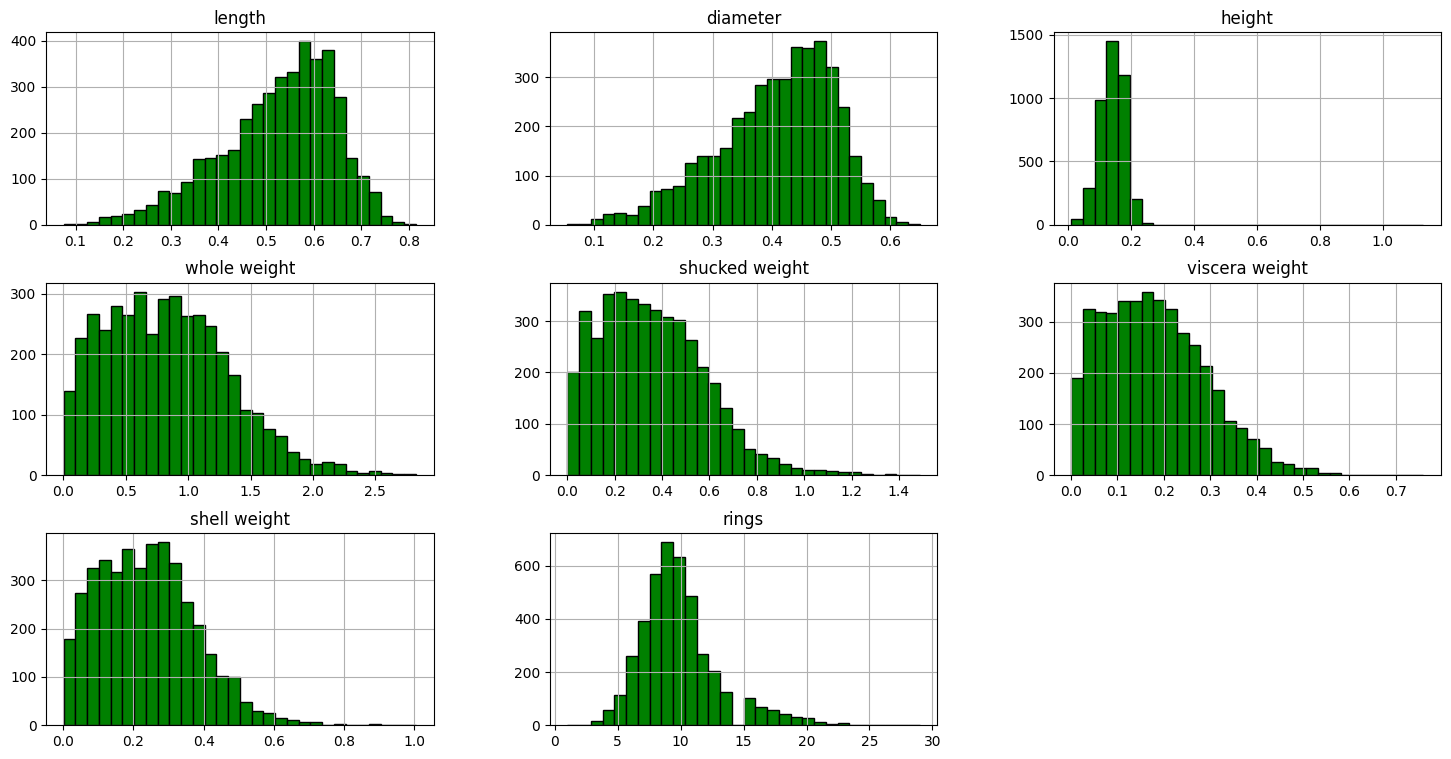

In [9]:
# Lets now start looking into the features
abalone.hist(figsize = (18,9), bins = 30, edgecolor = 'black', color = 'green')
plt.show()

Using a correlation heatmap is very beneficial to determine what features need to be selected in order to provide accurate models. As we can see in the very right column which shows the correlation each feature has with the target, the overall correlation is quite moderate with 'shucked weight' being the least. We will need to drop this feature. 

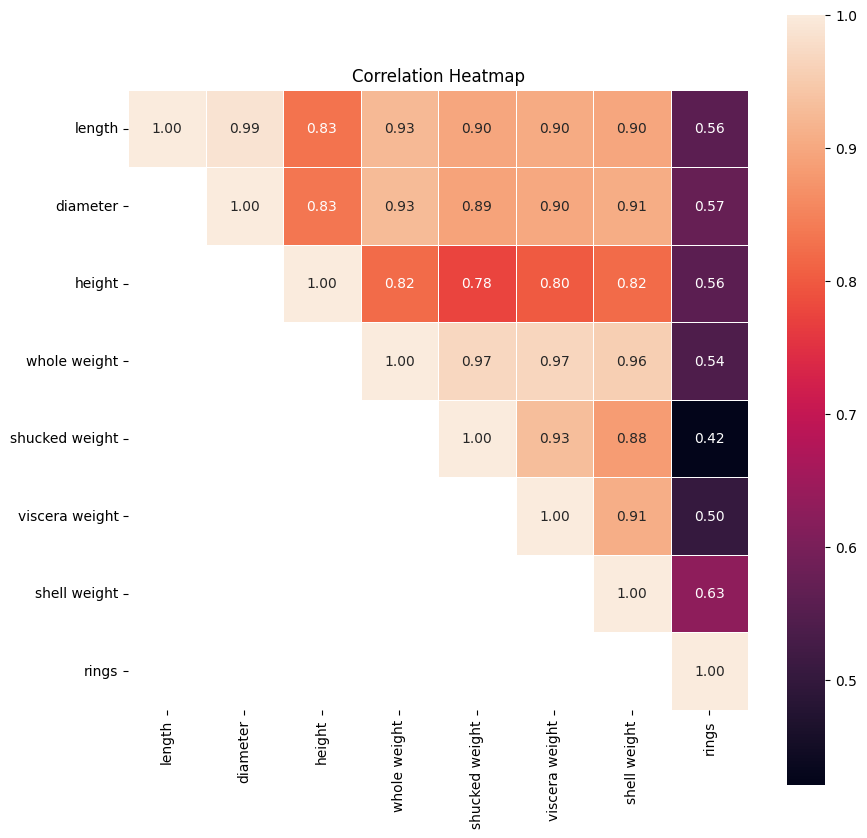

In [10]:
# Correlation Matrix
corr_abalone = abalone.corr(method = 'pearson')
abalone_ut = corr_abalone.where(np.triu(np.ones(corr_abalone.shape)).astype(np.bool))
    
# Heatmap
plt.figure(figsize = (10, 10))
heatmap(abalone_ut, annot = True, square = True, cbar = True, linewidths = .5, fmt = '.2f')
plt.title('Correlation Heatmap')
plt.show()

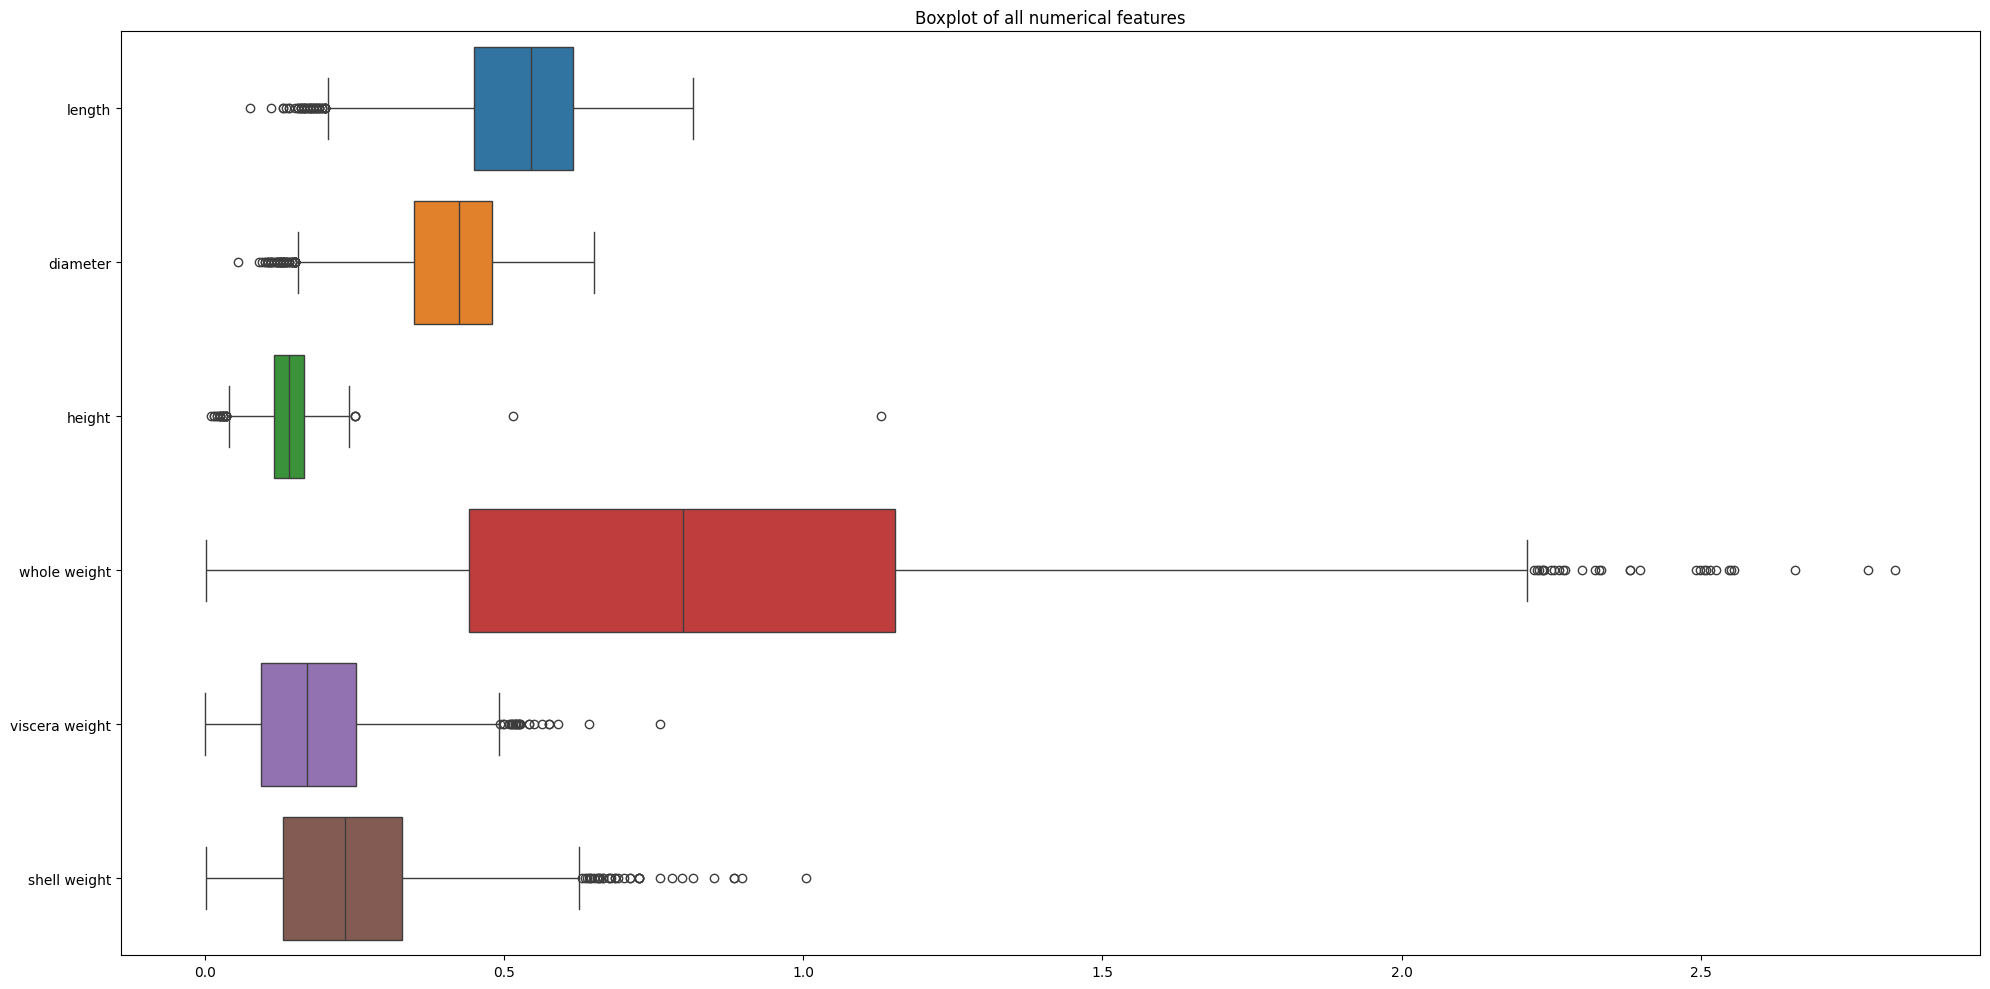

In [11]:
# Features // We remove Shucked weight because according to the heatmap it has a low correlation with the ring count
X = abalone[['length', 'diameter', 'height', 'whole weight',
             'viscera weight', 'shell weight']]
y = abalone['rings']

# Lets take a look if there are any outliers

plt.figure(figsize = (20,10))
boxplot(data = X, orient = 'h')
plt.title('Boxplot of all numerical features')
plt.tight_layout()
plt.show()

As we can see with the boxplot our features have a lot of outliers within the data. We have two choices, one we can remove these outlier to reduce noise at the risk of removing beneficial data points, or we can choose to keep them. In this case we choose to keep them as we have already determined that they are beneficial. As seen below however, is a way to remove the outliers using the Inner Quartile Range, we will not be using this.

In [12]:
# def remove_outliers_iqr(df):
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1 # %50

#     # Define the lower and upper bounds
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter out outliers
#     return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# print(f"Old dataframe shape: ", abalone.shape)
# # Remove outliers from all columns
# abalone = remove_outliers_iqr(abalone)
# print(f"New dataframe shape: ", abalone.shape)

# 3. Scaling and Splitting the Data
Now we will begin splitting the dataset into two parts which 30% is used for testing our machine learning models and the remaining 70% is for training the models. Our features (X) are all our features besides 'shucked weight' and our target is 'rings' or the age of the abalone. 

In [13]:
# Test Train Split
X = abalone[['length', 'diameter', 'height', 'whole weight',
             'viscera weight', 'shell weight']]
y = abalone['rings']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,
                                                     random_state = 42)

print(X_test)
print(X_train)
print(f'1254 plus 2923 is {1254 + 2923}')


      length  diameter  height  whole weight  viscera weight  shell weight
866    0.605     0.455   0.160        1.1035          0.3015         0.325
1483   0.590     0.440   0.150        0.8725          0.2150         0.245
599    0.560     0.445   0.195        0.9810          0.2245         0.335
1702   0.635     0.490   0.170        1.2615          0.2665         0.380
670    0.475     0.385   0.145        0.6175          0.1080         0.215
...      ...       ...     ...           ...             ...           ...
162    0.610     0.485   0.175        1.2445          0.2970         0.345
2206   0.290     0.225   0.075        0.1400          0.0235         0.040
3980   0.525     0.410   0.115        0.7745          0.1630         0.180
3075   0.680     0.520   0.185        1.4940          0.3935         0.406
2148   0.415     0.310   0.090        0.3245          0.0735         0.115

[1254 rows x 6 columns]
      length  diameter  height  whole weight  viscera weight  shell weight


Scaling/standardizing our features is good practice for machine learning tasks as it can improve prediction accuracy. 

In [14]:
# Rescaling the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print(X_test)
print(X_train)

[[ 0.65877789  0.45938573  0.46770726  0.54303907  1.0915546   0.59567025]
 [ 0.53346719  0.30783562  0.23146407  0.07352196  0.29950153  0.02642822]
 [ 0.28284579  0.35835232  1.29455842  0.29405272  0.38649002  0.6668255 ]
 ...
 [-0.00954585  0.0047354  -0.5953871  -0.12566712 -0.17664598 -0.43608092]
 [ 1.28533139  1.11610287  1.05831523  1.33674656  1.93396943  1.1720278 ]
 [-0.92849099 -1.00559866 -1.18599507 -1.04031083 -0.99616909 -0.89859007]]
[[-0.00954585  0.20680221 -0.12290072  0.01457825 -0.02098237 -0.42540763]
 [-0.80318028 -0.85404855 -0.94975188 -0.95900917 -0.91375895 -0.96974532]
 [-0.59432912 -0.60146504 -0.83163029 -0.85433328 -0.78098705 -0.68512431]
 ...
 [-0.13485655 -0.14681471 -0.35914391 -0.51998018 -0.44676812 -0.37915672]
 [ 0.40815649  0.56041914 -0.4772655   0.44141199  0.33154992 -0.04472703]
 [ 0.57523742  0.66145254  0.46770726  0.61824311  0.44600846  0.21143188]]


# 4. Regression Model 1 K-Nearest Neighbor Regression and Hyperparameter Tuning
To be able to have the most accurate possible we will use GridSearchCV with 10 folds to find the optimal n neighbor with the highest R-squared.

In [15]:
# KNeighborsRegressor
knn = KNeighborsRegressor()

# Define the parameter grid from 1 - 100
param_grid = {'n_neighbors': range(1,101)}

# Grid search with 10 folds
grid_search = GridSearchCV(knn, param_grid, cv = 10, scoring = 'r2', n_jobs = -1)
grid_search.fit(X_train,y_train)

# Get Scores
mean_scores = grid_search.cv_results_['mean_test_score']

best_n_neighbor = grid_search.best_params_['n_neighbors']

print(f'The optimal n is: {best_n_neighbor}')

The optimal n is: 16


In [16]:
# Initialize the KNN Regressor with the best number of neighbors
knn = KNeighborsRegressor(n_neighbors = best_n_neighbor)

# Fit the model
knn_regressor = knn.fit(X_train, y_train)

# Make predictions
test_predictions = knn_regressor.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print("K Nearest Neighbor Regressor Evaluation:")
print(f'Training R² Score with best neighbors: ' + str(knn_regressor.score(X_train, y_train)))
print(f'Testing R² Score with best neighbors: ' + str(knn_regressor.score(X_test, y_test)))
print(f'Mean Absolute Error: ' + str(mae))
print(f'Mean Squared Error: ' + str(mse))

K Nearest Neighbor Regressor Evaluation:
Training R² Score with best neighbors: 0.5513690040424007
Testing R² Score with best neighbors: 0.4811569379139319
Mean Absolute Error: 1.638755980861244
Mean Squared Error: 5.268621660685805


After fitting the training data to the model using hyperparameter tuning we can see that the model accurately predicts the data 55.14% of the time, not great but also not too bad. We can also see that the model performed worse with the testing data at 48.12% accuracy. The MAE is 1.64 which means the model had an error of 1.64 rings compared to the actual data and MSE being far higher. In general for MSE and MAE, lower is better meaning these values are not good given the context is years. Also having a lower accuracy with the testing data hints at overfitting which can be a variety of issues. One such issue can be too much noise or outliers, but given the box of code above using Interquartile Range, this was not the case and actually made the model perform worse. Could this be due to the slight skew of the data or something else?


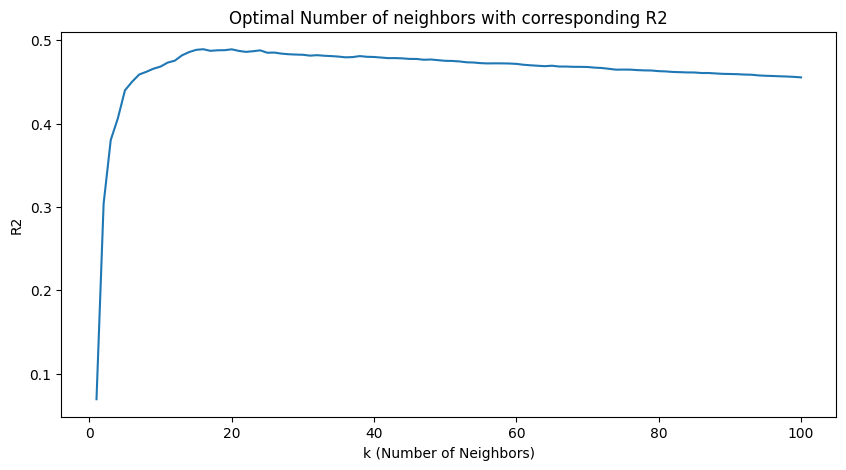

The optimal number of neighbors is: 16
The optimal R2 score is: 0.48937345554851197


In [17]:
# Lets take a look as to why
# Plot
plt.figure(figsize = (10, 5))
plt.plot(range(1, 101), mean_scores)
plt.title('Optimal Number of neighbors with corresponding R2')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R2')
plt.show()

# Best n-neighbors and R2
print(f'The optimal number of neighbors is: ' + str(grid_search.best_params_['n_neighbors']))
print(f'The optimal R2 score is: {grid_search.best_score_}')

Here is a short description of how the optimal number of neighbors is selected. As shown on the graph the optimal R2 has no possibility of being over 50%. 

# 5. Regression Model 2 Decision Tree Regression and Hyperparameter Tuning
Decision tree regression has a number of aspects that makes it better for our situation. Key differences with Decision Tree Regression is that non-linearity does not affect performance, it automatically handles missing values/outliers and it is more robust to irrelavant features. Lets see how it performs with the data!

In [18]:
# Lets use GridSearchCV to find the optimal max depth

# DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state = 42)


# Define the hyperparameter grid from 1 to 30
param_grid = {'max_depth': range(1,31)}

# Grid search
grid_search = GridSearchCV(estimator = tree, param_grid = param_grid, scoring = 'r2', cv = 10, n_jobs = -1 )
grid_search.fit(X_train, y_train)

# Get the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print(f"Optimal max_depth: {best_max_depth}")
print(f"Optimal R2 Score: {grid_search.best_score_}")


Optimal max_depth: 5
Optimal R2 Score: 0.4273542200303904


Using GridSearchCV again we can see the optimal max depth is 5 but the R2 score is lower. 

In [19]:
# Tree model with the optimal max_depth of 5
tree = DecisionTreeRegressor(max_depth = 5)

# Fit the model
tree_reg = tree.fit(X_train,y_train)

# Test predictions
train_predictions = tree_reg.predict(X_train)
test_predictions = tree_reg.predict(X_test)

# Evaluate the model
print("Decision Tree Regressor Evaluation:")
print("Training R² Score:", r2_score(y_train, train_predictions))
print("Testing R² Score:", r2_score(y_test, test_predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, test_predictions))
print("Mean Squared Error:", mean_squared_error(y_test, test_predictions))

Decision Tree Regressor Evaluation:
Training R² Score: 0.5125926638765128
Testing R² Score: 0.41353373772526325
Mean Absolute Error: 1.7495893196218855
Mean Squared Error: 5.955305329243391


Again according to R Squared again the data seems to be overfitting, not a good sign. Training accuracy at 51% and testing at 41% actually shows that our K-Nearest Neighbors model actually performed better. This can again could be due to a variety of different factors but by looking at the correlation map we can find our answer. 

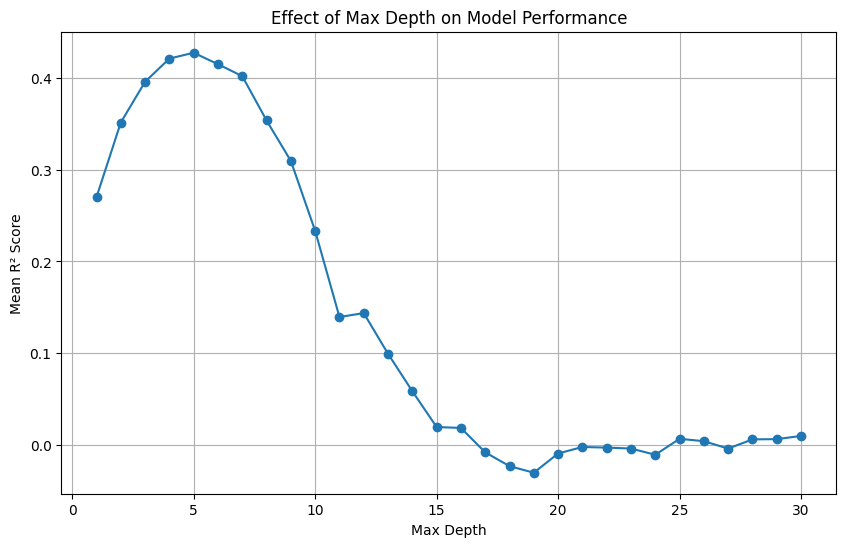

In [20]:
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
max_depths = param_grid['max_depth']

plt.figure(figsize = (10, 6))
plt.plot(max_depths, mean_test_scores, marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Mean R² Score')
plt.title('Effect of Max Depth on Model Performance')
plt.grid(True)
plt.show()


# 6. Conclusion/Summary
The purpose of this project was to see if we could predict the age of an abalone using features given in the data set. Although with subpar results, the results were as accurate as possible with both predictive models. We investigated the data and deducted what type of model would be most optimal. Our data involved regression rather than classification leading us to chose an appropriate model to suit the need, K-Nearest Neighbor Regression. After proper data munging and hyperparameter tuning we ducted the possibility of noise as the distribution of the data could be the issue. To figure out if that was truly the issue we used Decision Tree Regression which is a more robust supervised machine learning algorithm. To our suprise, the model performed worse than the K-Nearest Neighbor Regression. Looking back at the correlation heatmap we can see that all of the features had a very moderate correlation to our target being the number of rings. As seen in the UCI repository a note saying that other possible measurements such as weather patterns and location (hence food availability) may be required to solve the problem. To make an inference of the data I believe to be able to accurately predict the age of an abalone, measurements need to be redone due to the large amount of outliers in the data as well as more features that are more enriching are required as well. I believe this is a good excerise however as it demonstrates fimiliarity with these machine learning models while also demonstrating conclusive data analysis skills. 
